# 特征增强：数据清洗

本章内容：

- 识别数据中的缺失值
- 删除有害数据
- 输入（填充）缺失值 
- 对数据进行归一化/标准化 
- 构建新特征 
- 手动或自动选择（移除）特征
- 使用矩阵运算将数据集转换到不同的维度

## 3.1 识别数据中的缺失值

数据的缺失主要包括**记录(行）的缺失**和记录中某个**字段（列）的缺失**，两者都会造成分析结果不准确。

### 缺失值产生的原因

1. 信息无法获取或获取的代价大
2. 遗漏
3. 属性值不存在，如未婚者的配偶姓名

### 缺失值的影响

1. 丢失对机器学习模型有用的信息
2. 导致模型难以把握数据中蕴含的规律
3. 包含空值的数据会使建模过程陷入混乱，输出不可靠

### 缺失值的分析

对缺失值的分析主要从以下两方面进行：

1. 使用简单的**统计分析**，可以得到含有缺失值的属性的个数以及每个属性的未缺失数、缺失数与缺失率等
2. 对于**缺失值的处理**，从总体上来说分为**删除**存在缺失值的记录、对可能值进行**填充**。

### 示例：皮马印度安人糖尿病预测数据集

#### 了解数据

先深入了解一下本章要使用的数据集：皮马印度安人糖尿病预测数据集（pima-indians-diabetes.csv）。此公开数据集来源于kaggle，9列768行。此数据集希望通过体检结果，预测21岁以上的女性皮马印度安人5年内是否会患糖尿病。
此数据集对应于机器学习中的二分类问题。根据Kaggle网站提供的信息，数据每列（按顺序）的含义如下：

1. Pregnancies：怀孕次数
2. Glucose：葡萄糖浓度（口服葡萄糖耐量试验中2小时血浆葡萄糖浓度）
3. BloodPressure：血压（mmHg）
4. SkinThickness：皮褶厚度（mm)
5. Insulin：胰岛素浓度（μU/ml）
6. BMI：体重指数
7. DiabetesPedigreeFunction：糖尿病家族函数
8. Age：年龄
9. Outcome：分类结果（0/1，无/有糖尿病）

对此数据集，最终的目标是向机器学习模型输入8个特征值来预测最后一列分类变量的值，即某人是否患有糖尿病。

#### 探索性数据分析

首先进行探索性数据分析（EDA，Exploratory Data Analysis)来识别缺失值：

In [3]:
# 导入探索性数据分析所需的包

# 表格数据分析包
import pandas as pd
# 数学计算包
import numpy as np
# 数据可视化包
import matplotlib.pyplot as plt
# 增强的数据可视化包
import seaborn as sns
# 使用数据可视化主题
plt.style.use('fivethirtyeight')

导入数据集：

In [4]:
!ls sample_data

2013-sfo-customer-survey.csv
DataDictionary_2013-SFO-Customer-Survey.pdf
GlobalLandTemperaturesByCountry.csv
pima-indians-diabetes.csv
salary-ranges-by-job-classification.csv


In [5]:
pima = pd.read_csv('sample_data/pima-indians-diabetes.csv')
pima.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


Opps，表格没有列名。看一下CSV文件内容：

In [6]:
!head -n 5 sample_data/pima-indians-diabetes.csv 

6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


CSV文件中确实没有标题行。只能根据kappa网站提供的信息手动添加了：

In [10]:
pima_column_names = ['Pregnancies', 'Glucose', 
                     'BloodPressure', 'SkinThickness', 
                     'Insulin','BMI', 'DiabetesPedigreeFunction', 
                     'Age', 'Outcome']
pima = pd.read_csv('sample_data/pima-indians-diabetes.csv', names=pima_column_names)
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


先计算一下糖尿病的患病率：

In [11]:
pima['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

可见，患病率约35%。既然最终目标是研究数据规律以预测某人是否会患糖尿病，可以对糖尿病和健康人的区别进行可视化。下面通过直方图显示二者在葡萄糖浓度之间的差异：

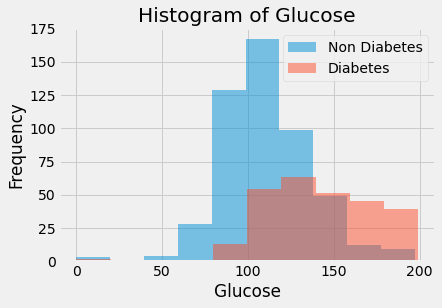

In [14]:
plt.hist(pima[pima['Outcome']==0]['Glucose'], 10, 
         alpha=0.5, label='Non Diabetes')
plt.hist(pima[pima['Outcome']==1]['Glucose'], 10, 
         alpha=0.5, label='Diabetes')

plt.legend(loc='upper right')
plt.xlabel('Glucose')
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format('Glucose'))

plt.show()

可见，糖尿病患者和常人的葡萄糖浓度差异很大。继续绘制其他列的直方图：

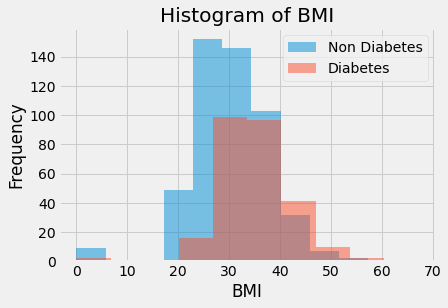

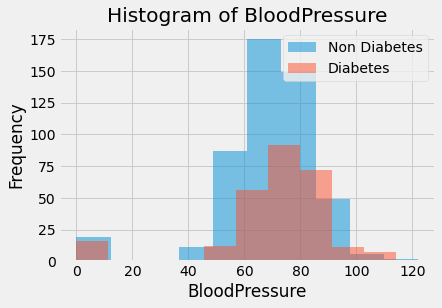

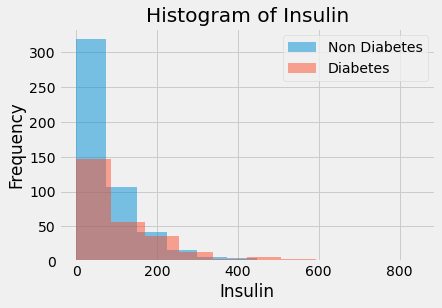

In [17]:
for col in ['BMI', 'BloodPressure', 'Insulin']:
    plt.hist(pima[pima['Outcome']==0][col], 10, alpha=0.5, label='Non Diabetes')
    plt.hist(pima[pima['Outcome']==1][col], 10, alpha=0.5, label='Diabetes')
    
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))

    plt.show()

看起来，两类人在BMI、血压和胰岛素浓度方面有明显差别。可以用线性相关矩阵来量化这些变量间的关系。这里可以使用Seaborn作为可视化工具绘制相关矩阵的热力图:

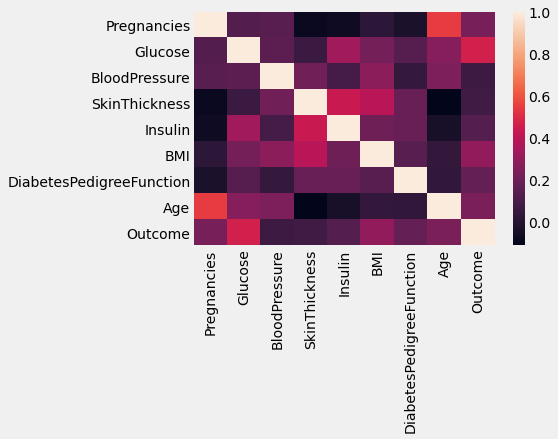

In [19]:
sns.heatmap(pima.corr())
plt.show()

相关矩阵显示，葡萄糖浓度(Glucose）跟糖尿病（Outcome）有很强的相关性（浅红色方块）。下面具体看一下Outcome的相关性系数值：

In [20]:
pima.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

可见，探索性数据分析（EDA）告诉我们，葡萄糖浓度（Glucose）是预测糖尿病的重要变量。
下一步，要看一下数据集中是否有缺失值：

In [22]:
pima.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

数据中没有缺失值。继续探索数据，看看数据的行数和列数：

In [24]:
pima.shape

(768, 9)

再查看基本描述性统计：

In [25]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


不对，BMI的最小值是0，这有悖医学常识，可能数据中的缺失值都用0填充了。而且，除了DiabetsPedigreeFunction和Age，其余列的最小值都是0。其中Outcome中的0代表没有糖尿病，人也可以怀孕0次，说明这两列没问题。下面这些列的缺失值用0填充了：

- Glucose（葡萄糖浓度）
- BloodPressure（血压）
- SkinThickness（皮褶厚度）
- Insulin（胰岛素浓度）
- BMI（体重身高比）

这说明数据中存在缺失值，只是被0填充过了。不要以为null、nan或空白才是缺失值，0也可能是数值型变量的缺失值，判断和填充的方法就要结合常识、业务知识和数据集的相关文档。

如果数据集没有文档，缺失值的默认填充方法有：

- 0 （数值型），如本例
- unknown（类别型）
- ？（类别型）

**识别**了数据集中的缺失值，下一步就是**处理**数据集中（上述5列）存在的缺失值。

## 3.2 处理数据集中的缺失值

缺失值的处理办法主要有两种：

- 删除缺少值的行
- 填充缺失值

在进一步处理前，先用None填充所有的数字0，这一就能使用Pandas的fillna和dropna填充和删除缺失值了：

In [26]:
# 被错误填充的缺失值是0
pima['Insulin'].isnull().sum()

0

In [28]:
pima['Insulin'] = pima['Insulin'].map(lambda x: x if x!= 0 else None)

In [29]:
pima['Insulin'].isnull().sum()

374

也可以用for循环和内置的replace方法快速将0替换为None:

In [31]:
cols = ['Insulin', 'BMI', 'BloodPressure', 'Glucose', 'SkinThickness']

for col in cols:
    pima[col].replace([0], [None], inplace=True)

重新统计缺失值的数量：

In [32]:
pima.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

现在数据有意义多了，可见其中5列有缺失值，缺失程度也不一样。有些列，如Glucose（葡萄糖浓度）只缺少5个值，但Insulin（胰岛素浓度）差不多缺失一半。

In [33]:
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,NaN,33.6,0.627,50,1
1,1,85,66,29,NaN,26.6,0.351,31,0
2,8,183,64,None,NaN,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1


通过将缺失值出入数据集，缺失的数据不在是原来的占位符0。这样，EDA更准确：

In [34]:
pima.describe()

,Pregnancies,Insulin,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,394.000000,768.000000,768.000000,768.000000
mean,3.845052,155.548223,0.471876,33.240885,0.348958
std,3.369578,118.775855,0.331329,11.760232,0.476951
min,0.000000,14.000000,0.078000,21.000000,0.000000
25%,1.000000,76.250000,0.243750,24.000000,0.000000
50%,3.000000,125.000000,0.372500,29.000000,0.000000
75%,6.000000,190.000000,0.626250,41.000000,1.000000
max,17.000000,846.000000,2.420000,81.000000,1.000000


注意，describe方法不包括有缺失值的列。尽管存在缺失值，但可以对某些列取均值和标准差：

In [35]:
pima['Glucose'].mean(), pima['Glucose'].std()

(121.6867627785059, 30.53564107280403)

### 删除有害的行

在处理缺失数据的两种办法中，最常见也最容易的方法就是**直接删除**存在缺失值的**行**，这样可以保证数据的完整性。使用Pandas的dropna即可删除存在缺失值的行：

In [36]:
pima_dropped = pima.dropna()
# 计算删除行的占比
lost_percent = round(100 * pima_dropped.shape[0])/float(pima.shape[0])

print('{}% 的行被删除掉了！'.format(lost_percent))

51.041666666666664% 的行被删除掉了！


丢失了51%的行！从机器学习角度，尽管数据都有值、很干净，但丢失的数据太多，没有利用尽可能多的数据，这对学习效果非常不利。

下面对数据集进一步探索性数据分析，比较一下丢弃缺失值前后的统计结果。

- 丢弃前的统计结果：

In [37]:
pima['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

- 丢弃后的统计结果：

In [39]:
pima_dropped['Outcome'].value_counts(normalize=True)

0    0.668367
1    0.331633
Name: Outcome, dtype: float64

看来丢弃前后二分类（0/1）的比例差不多，对结果响应不大。再比较一下丢弃缺失值前后的均值和数据的形状。

- 丢弃前的均值

In [40]:
pima.mean()

Pregnancies                   3.845052
Glucose                     121.686763
BloodPressure                72.405184
SkinThickness                29.153420
Insulin                     155.548223
BMI                          32.457464
DiabetesPedigreeFunction      0.471876
Age                          33.240885
Outcome                       0.348958
dtype: float64

- 丢弃后的均值

In [41]:
pima_dropped.mean()

Pregnancies                   3.301020
Glucose                     122.627551
BloodPressure                70.663265
SkinThickness                29.145408
Insulin                     156.056122
BMI                          33.086224
DiabetesPedigreeFunction      0.523046
Age                          30.864796
Outcome                       0.331633
dtype: float64

为了更好地了解丢弃前后均值的变化情况，创建一个新的图表，将每列均值变化的百分比可视化。
首先，创建一个表格，列出每列均值变化的百分比：

In [43]:
pima_mean_delta = (pima_dropped.mean() - pima.mean()) / pima.mean()
pima_mean_delta

Pregnancies                -0.141489
Glucose                     0.007731
BloodPressure              -0.024058
SkinThickness              -0.000275
Insulin                     0.003265
BMI                         0.019372
DiabetesPedigreeFunction    0.108439
Age                        -0.071481
Outcome                    -0.049650
dtype: float64

用条形图对这些变化进行可视化：

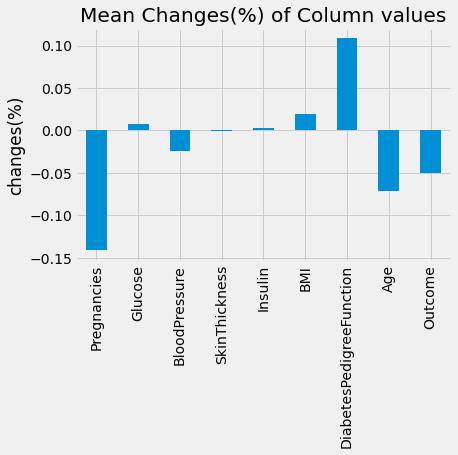

In [47]:
ax = pima_mean_delta.plot(kind='bar', 
                          title='Mean Changes(%) of Column values')
ax.set_ylabel('changes(%)')

plt.show()

可见，Pregnancies（怀孕次数）的均值在删除缺失值后下降了14%，变化很大。DiabetesPedigreeFunction（糖尿病家族函数）上升了11%，变化也很大。这说明，删除行会严重影响数据的形状，因此应该保留尽可能多的数据。

为了了解丢弃行的数量（比例）对最终机器学习模型效果的影响，先使用删除缺失值的数据进行一下机器学习：

1. 导入KNN分类器和网格搜索模块：

In [48]:
# 使用scikit-learn的K最近领(KNN)分类模型和网格搜索模块
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

2. 用删除缺失值的数据集为预测模型创建X（特征矩阵）和y变量（响应变量）：

In [50]:
X_dropped = pima_dropped.drop('Outcome', axis=1)
y_dropped = pima_dropped['Outcome']
print('学习的行数：{}'.format(X_dropped.shape[0]))

学习的行数：392


3. 为网格搜索创建所需的参数和实例：

In [51]:
# KNN参数
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
# 实例化KNN分类器和网格搜索对象
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)

4. 使用特征矩阵和响应变量进行拟合（训练），并输出最佳准确率和最佳参数:

In [52]:
# 拟合（训练）
grid.fit(X_dropped, y_dropped)
# 输出最佳准确率和最佳参数
grid.best_score_, grid.best_params_

(0.7348263550795197, {'n_neighbors': 7})

最近邻K为7，此时KNN模型（分类为0）的准确率是73.5%，比直接来自原始数据（分类为0）比率65%要好。但是，这个模型只用了49%的数据，如果能用到所有数据，是否准确率会更高？

虽然删除脏数据并不完全是特征工程，但这的确是一种数据清洗技术，以清洗机器学习流水线的输入。

### 填充缺失值

填充指的是利用现有知识/数据来确定缺失的数值并填充的行为。在各类填充方法中，最常见的是利用此列其余部分的均值填充缺失值：

In [53]:
pima.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

先看一下Glucose列的5个缺失值：

In [56]:
null_glucose_index = pima[pima['Glucose'].isnull()].index
pima.loc[null_glucose_index]['Glucose']

75     None
182    None
342    None
349    None
502    None
Name: Glucose, dtype: object

用内置的fillna方法，将所有的None填充为Glucose列其余数据的均值：

In [57]:
pima['Glucose'].fillna(pima['Glucose'].mean(), inplace=True)
pima.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

看一下填充后的Glucose列：

In [58]:
pima.loc[null_glucose_index, 'Glucose']

75     121.686763
182    121.686763
342    121.686763
349    121.686763
502    121.686763
Name: Glucose, dtype: float64

原来的None被该列的均值121.68替换了。我们要填充的列共有5个，如果其他列也这么填充太麻烦了。别担心，scikit-learn的估算(impute)器模块可以帮我们快速搞定：

In [63]:
# 导入impute模块的SimpleImputer类
from sklearn.impute import SimpleImputer

# 实例化Imputer, 缺失值的估算策略为均值(mean)或中位数
imputer = SimpleImputer(strategy='mean')
# 拟合并计算所有缺失值
pima_imputed = imputer.fit_transform(pima)
pima_imputed

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

有个小问题，SimpleImputer的输出不是Pandas的DataFrame，而是Numpy数组：

In [64]:
type(pima_imputed)

numpy.ndarray

解决办法很简单，pandas可以将任何数组直接转换为DataFrame:

In [65]:
pima_imputed = pd.DataFrame(pima_imputed, columns=pima_column_names)
pima_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.00000,155.548223,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.00000,155.548223,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,29.15342,155.548223,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1.0


比较一下：

In [67]:
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,NaN,33.6,0.627,50,1
1,1,85.0,66,29,NaN,26.6,0.351,31,0
2,8,183.0,64,None,NaN,23.3,0.672,32,1
3,1,89.0,66,23,94.0,28.1,0.167,21,0
4,0,137.0,40,35,168.0,43.1,2.288,33,1


可见，缺失值被估算器计算出的中值替换。检查一下Glucose列的填充值是否跟之前的手动计算是否相同：

In [68]:
pima_imputed.loc[null_glucose_index, 'Glucose']

75     121.686763
182    121.686763
342    121.686763
349    121.686763
502    121.686763
Name: Glucose, dtype: float64

最后检查一下，所有缺失值是否都被替换：

In [70]:
pima_imputed.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

非常棒。估算器SimpleImputer很大程度上解决了填充缺失值的琐事。尝试填充其他值，看看对KNN模型的影响。

先从最简单的填充方法（将所有缺失值替换为0）开始：

In [71]:
pima_zero = pima.fillna(0)

X_zero = pima_zero.drop('Outcome', axis=1)
print('正在从{}行数据中学习...'.format(X_zero.shape[0]))
y_zero = pima_zero['Outcome']

knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(knn, knn_params)
grid.fit(X_zero, y_zero)

grid.best_score_, grid.best_params_

正在从768行数据中学习...


(0.7409387997623291, {'n_neighbors': 7})

可见，如果用0填充，准确率(74%）比直接删除有缺失值（73.5%）好一点。能不能更好呢？

### 在机器学习流水线中填充值

如果想把Imputer转移到机器学习**流水线**（pipeline）上，先学习一下关于流水线的概念。

#### 机器学习流水线

机器学习流水线是指在原始数据在被解读为最终输出之前，经过的各种**预处理**步骤，乃至多种**学习算法**。针对机器学习流水线通常包含很多步骤对数据进行转换和预测，scikit-learn提供了用于构建流水线的内置模块。

用Imputer类填充值的时候不使用流水线其实是很不恰当的，因为学习算法的目标是泛化**训练集**的模式并将其应用于**测试集**。如果在划分数据集和应用算法之前直接对整个数据集填充值，就是在作弊，模型学不到任何模式。为此，对数据集进行一次划分，对于交叉验证，可能会进行多次划分。

In [72]:
# 导入划分模块
from sklearn.model_selection import train_test_split
X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

X.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

进行一次划分。划分前，对整个数据集填充变量X的均值：

In [108]:
# 不恰当的做法：划分前填充缺失值
X_mean = X.mean()
X = X.fillna(X_mean)
# 划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
# 用KNN模型和网格搜索拟合训练集
knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(knn, knn_params)
grid.fit(X_test, y_test)
print('训练准确率：', grid.best_score_, grid.best_params_)
# 用测试集评分
print('测试准确率：', grid.score(X_test, y_test))

训练准确率： 0.7388663967611336 {'n_neighbors': 4}
测试准确率： 0.8333333333333334


结果看起来不错。但由于训练集和测试都是用整个X矩阵（数据集）的均值填充的，违反了机器学习流程的核心原则：当预测测试集的响应值时，不能假设已经知道了整个数据集的均值，这等于让模型利用测试集的信息来拟合训练集（这相当于高考前漏了题）。因此，上述测试集上的评分不真实。

现在用恰当的方法再做一遍：

In [80]:
# 恰当的做法：划分后填充值
X = pima.drop('Outcome', axis=1)
y = pima['Outcome']
# 划分,使用相同的随机状态，保证划分不变
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
X.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [84]:
# 用训练集的均值填充训练集和测试集的缺失值
X_train_mean = X_train.mean()
X_train = X_train.fillna(X_train_mean)
X_test = X_test.fillna(X_train_mean)
# 比较一下训练集的均值和整个数据集的均值
X_train_mean, X_mean

(Pregnancies                   3.805556
 Glucose                     122.100799
 BloodPressure                72.829137
 SkinThickness                29.203883
 Insulin                     158.546053
 BMI                          32.455245
 DiabetesPedigreeFunction      0.479524
 Age                          33.248264
 dtype: float64,
 Pregnancies                   3.845052
 Glucose                     121.686763
 BloodPressure                72.405184
 SkinThickness                29.153420
 Insulin                     155.548223
 BMI                          32.457464
 DiabetesPedigreeFunction      0.471876
 Age                          33.240885
 dtype: float64)

In [107]:
# 用KNN模型和网格搜索拟合训练集
knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(knn, knn_params)
grid.fit(X_test, y_test)
print('训练准确率：', grid.best_score_, grid.best_params_)
# 用测试集评分
print('测试准确率：', grid.score(X_test, y_test))

训练准确率： 0.7288798920377867 {'n_neighbors': 6}
测试准确率： 0.8229166666666666


训练和测试准确率都低了一些，但至少更诚实地代表了模型的泛化能力，即从训练集的特征中学习并将所学应用到未知隐藏数据上的能力。

为了确保机器学习流失线的各个步骤的结构和顺序是恰当的，scikit-learn提供了Pipeline。下面看看如何结合使用scikit-learn的Pipeline和Imputer：

In [110]:
# 导入流水线
from sklearn.pipeline import Pipeline

# 重新定义参数以符合流水线
knn_params = {'classify__n_neighbors': list(range(1,8))}

# 流水线
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('classify', KNeighborsClassifier())
])

# 准备特征矩阵X和响应变量y
X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

# 定义搜索网格
grid = GridSearchCV(pipe, knn_params)

grid.fit(X, y)
grid.best_score_, grid.best_params_

(0.7318394024276378, {'classify__n_neighbors': 7})

Pipeline类替我们处理了大部分流程：恰当地从多个训练集取值并用其填充测试集的缺失值并测试KNN的泛化能力，最终输出性能最佳的模型。下面修改缺失值的填充策略为中位数（median），再来一次：

In [115]:
# 重新定义参数以符合流水线
knn_params = {'classify__n_neighbors': list(range(1,8))}

# 流水线
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('classify', KNeighborsClassifier())
])

# 准备特征矩阵X和响应变量y
X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

# 定义搜索网格
grid = GridSearchCV(pipe, knn_params)

grid.fit(X, y)
grid.best_score_, grid.best_params_

(0.7292589763177999, {'classify__n_neighbors': 7})

如果只看训练准确率，似乎全部填充为0最高（74%）。只靠scikit-learn的Pipeline和Imputer还不够，为此，我们需要引入全新的特征工程技巧：标准化和归一化。

## 3.3 标准化和归一化

目前，我们已经用过4种不同的方式处理数据集，为了进一步增强机器学习流水线，继续我们的EDA（探索性数据分析）之旅，找出提升模型泛化能力的有效特征和方法。首先看一下使用均值填充所有缺失值后各列的分布情况：

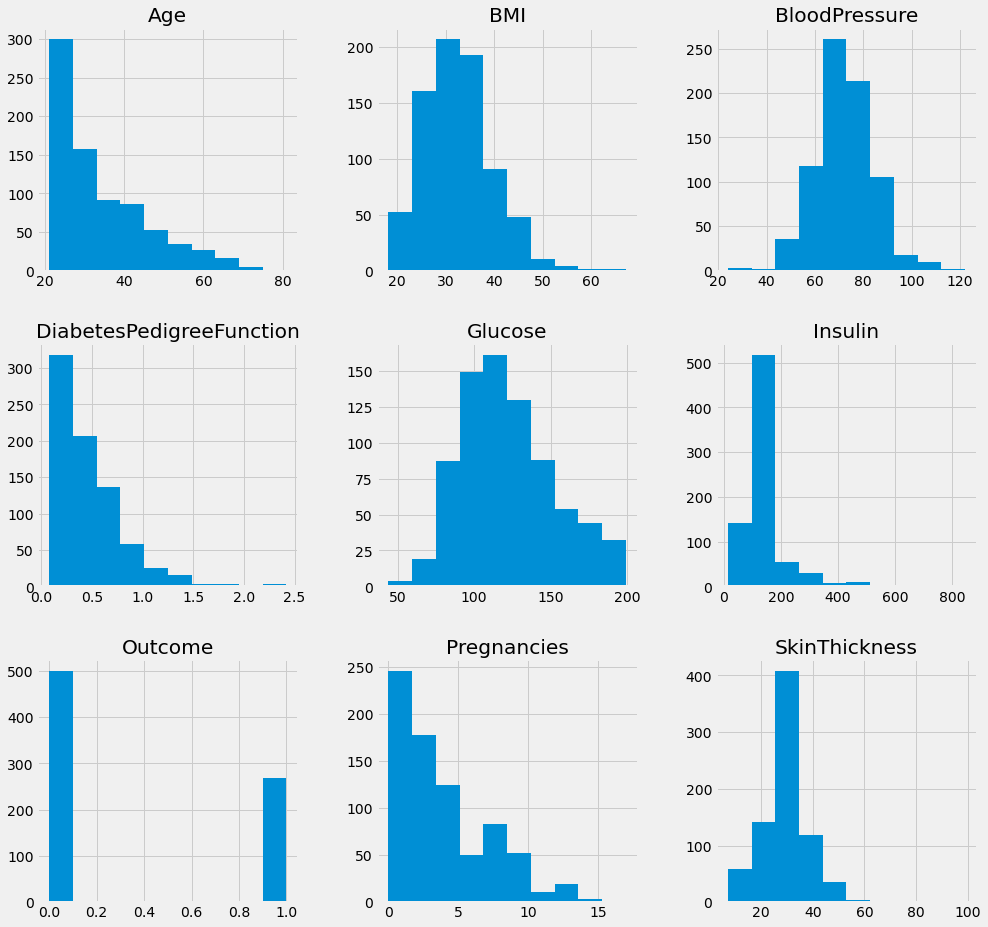

In [116]:
imputer = SimpleImputer(strategy='mean')
pima_imputed_mean = pd.DataFrame(imputer.fit_transform(pima), 
                                 columns=pima_column_names)
# 通过直方图查看9列的分布情况
pima_imputed_mean.hist(figsize=(15,15))
plt.show()

注意到，每列的均值、最小值、最大值和标准差的差别很大：

In [117]:
pima_imputed_mean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


这有何关系？因为某些机器学习模型受数据**尺度**（scale）的影响很大。也就是说，如果血压在24～122，年龄在21~81，那么算法无法达到最优化状态。可以在直方图中设置同样的比例查看每个图表：

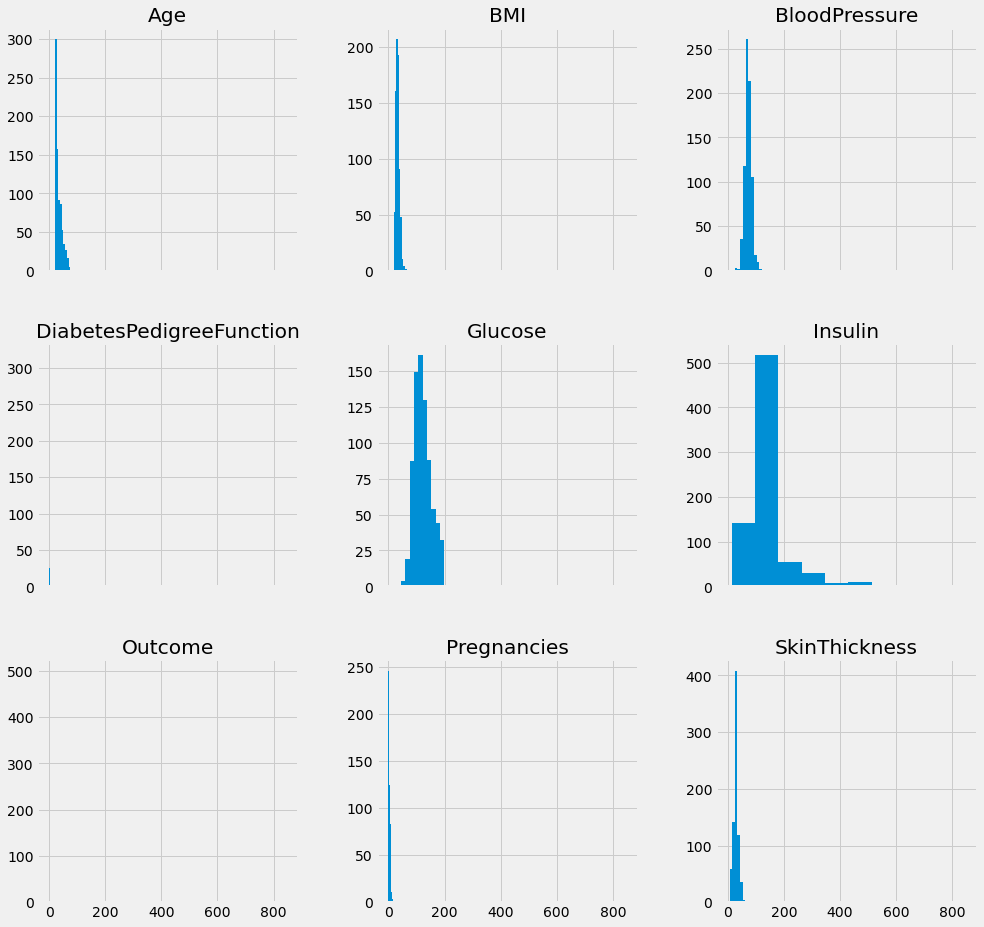

In [118]:
pima_imputed_mean.hist(figsize=(15, 15), sharex=True)
plt.show()

显然，所有的数据尺度都不同，这会导致尺度大的列（特征）会占主导地位，从而影响模型学习效果，过分在意某些特征，无法给出客观准确的预测。这就需要对数据进行**归一化**，将行和列对齐并转化为一致的规则。

常见的归一化/标准化方法：
- 将所有定量列转化为同一个静态范围中的值
- 令所有列的均值和标注差都相同

标准化通过确保所有行和列在机器学习中得到平等对待，让数据的处理保持一致。

### Z分数标准化

**Z分数标准化**是最常见的标准化技术，利用了统计学里简单的z分数（标准分数）思想。z分数标准化的输出会被重新缩放，使**均值为0**、**标准差为1**。通过缩放特征、统一化均值和方差（标准差的平方），可以让KNN这种模型达到最优化，而不会倾向于较大比例的特征。

公式：**z = (x- μ) / σ**，其中：

- z是新的值（z分数
- x是单元格原来的值
- μ是该列的均值
- σ是列的标准差

下面使用上述公式，对皮马数据集的Glucose列进行Z分数标准化：

In [119]:
# 得到该列的均值
mu = pima['Glucose'].mean()
# 的到该列的标准差
sigma = pima['Glucose'].std()
# 计算Z分数
z_score = (pima['Glucose'] - mu) / sigma
z_score.head()

0    0.864545
1   -1.205376
2    2.014501
3   -1.073952
4    0.503130
Name: Glucose, dtype: float64

其实，无需手工套用公式进行计算，scikit-learn中有内置对象帮助计算：

In [121]:
from sklearn.preprocessing import StandardScaler
# 先输出Glucose列Z分数标准化之前的均值和标准差以及直方图
mu, sigma

(121.68676277850587, 30.43594886720766)

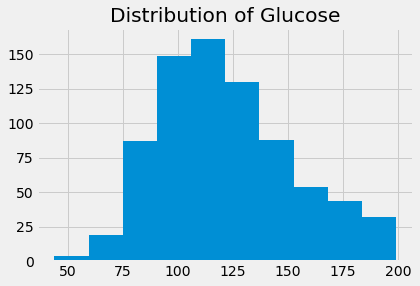

In [123]:
# 绘制直方图
ax = pima['Glucose'].hist()
ax.set_title('Distribution of Glucose')
plt.show()

现在应用Z分数标准化：

In [125]:
scaler = StandardScaler()
glucose_z_score_standardized = scaler.fit_transform(pima[['Glucose']])
glucose_z_score_standardized.mean(), glucose_z_score_standardized.std()

(-3.561965537339044e-16, 1.0)

应用缩放后，均值下降到0，标准差为1。再进一步查看缩放后数据的分布情况：

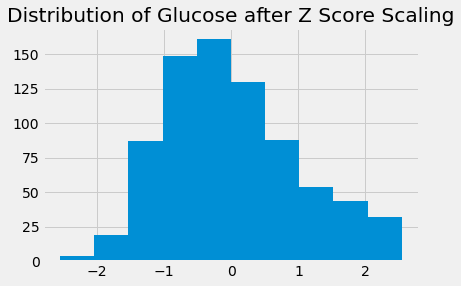

In [126]:
ax = pd.Series(glucose_z_score_standardized.reshape(-1,)).hist()
ax.set_title('Distribution of Glucose after Z Score Scaling')
plt.show()

观察到x轴更紧密了，y轴没变化，数据的形状没有变。下面对每一列都进行Z分数转换，在看一下直方图。

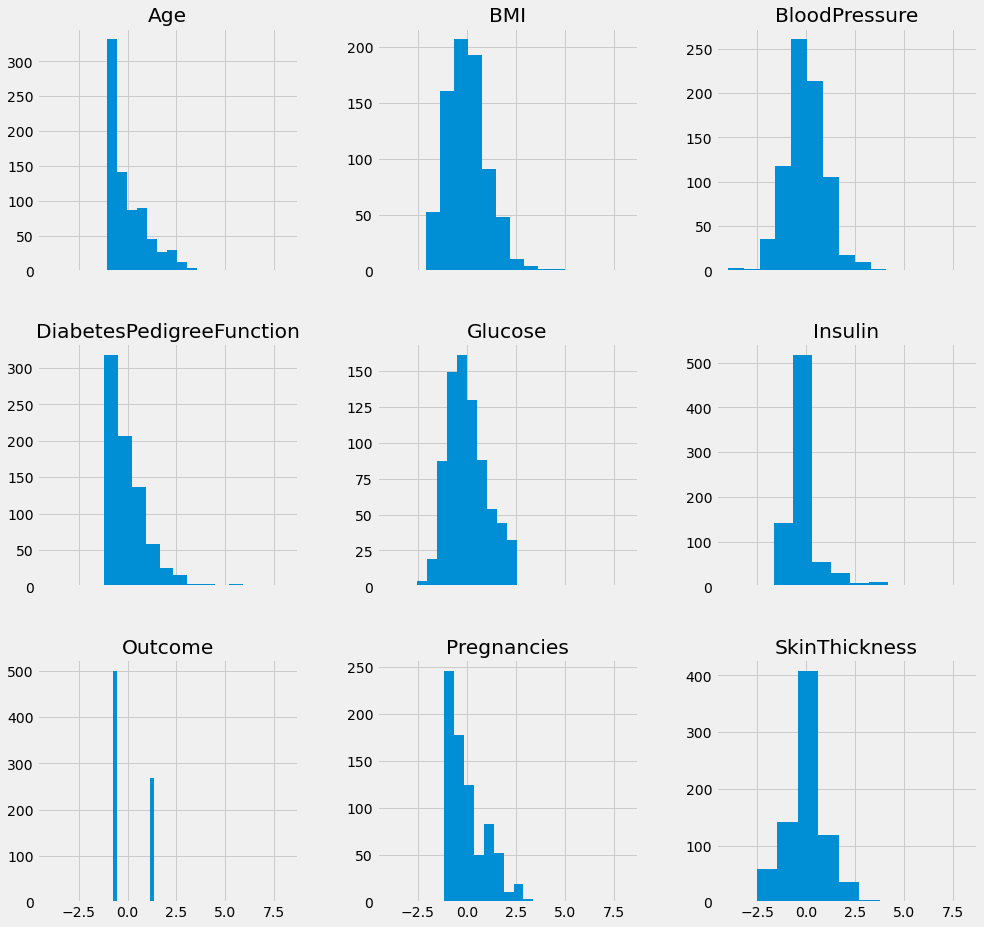

In [128]:
scaler = StandardScaler()
pima_imputed_mean_scaled = pd.DataFrame(scaler.fit_transform(pima_imputed_mean),
                                       columns=pima_column_names)
pima_imputed_mean_scaled.hist(figsize=(15, 15), sharex=True)
plt.show()

注意到整个数据集的x轴都更加紧密了。现在将StandardScaler插入之前的机器学习流水线中：

In [130]:
knn_params = {
    'imputer__strategy': ['mean', 'median'],
    'classify__n_neighbors': list(range(1,8))
}

pipe = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('standardize', StandardScaler()),
    ('classify', KNeighborsClassifier())
])

X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

grid = GridSearchCV(pipe, knn_params)
grid.fit(X, y)

grid.best_score_, grid.best_params_

(0.7539173245055598, {'classify__n_neighbors': 7, 'imputer__strategy': 'mean'})

填充策略都是均值并使用流水线的情况下，训练准确率和标准化之前（73%）相比，有了较大提升（75.4%）。这条流水线从整个768行中学习（尽可能多地保留数据）。现在看看另一种标准化方法。

### min-max标准化

min-max标准化的公式为：**m = (x - xmin) / (xmax - xmin)**，其中：

- m是新的值
- x是单元格原来的值
- xmin是该列的最小值
- xmax是该列的最大值

此公式会将每列所有的值限定于0～1。现在用scikit-learn的内置模块试试：

In [131]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

pima_min_maxed = pd.DataFrame(min_max_scaler.fit_transform(pima_imputed),
                             columns=pima_column_names)
pima_min_maxed.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.501205,0.493930,0.240798,0.170130,0.291564,0.168179,0.204015,0.348958
std,0.198210,0.196361,0.123432,0.095554,0.102189,0.140596,0.141473,0.196004,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.129207,0.190184,0.070773,0.050000,0.000000
50%,0.176471,0.470968,0.491863,0.240798,0.170130,0.290389,0.125747,0.133333,0.000000
75%,0.352941,0.620968,0.571429,0.271739,0.170130,0.376278,0.234095,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


可见，最小值都是0，最大值都是1。不过，这种缩放的副作用是标准差非常小，这可能不利于某些模型，因为异常值的权重降低了。现在，标准化方法插入机器学习流水线：

In [132]:
knn_params = {
    'imputer__strategy': ['mean', 'median'],
    'classify__n_neighbors': list(range(1,8))
}

pipe = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('standardize', MinMaxScaler()),
    ('classify', KNeighborsClassifier())
])

X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

grid = GridSearchCV(pipe, knn_params)
grid.fit(X, y)

grid.best_score_, grid.best_params_

(0.7630336983278159,
 {'classify__n_neighbors': 7, 'imputer__strategy': 'median'})

又有进步！min-max缩放后，训练准确率比采用Z分数标准化（75.4%）提高了近1分（76.3%）。看来min-max缩放对KNN的帮助较大。现在再试试第3种标准化方法，将关注点从列转移到行上。

### 行归一化

此标准化方法是**关于行**，而不是关于列的。**行归一化**不是计算每列的统计值（均值、最小值、最大值等），而是会保证每行有单位**范数**（unit norm），意味着每行的向量长度相同。

如果每行数据都在一个n维空间内，那么每行都有一个向量范数（长度）。也就是说，每行都是空间内的一个向量：x=(x1, x2,…, xn)，其中x1, x2,..., xn就是x的特征。

在皮马数据集中n=8,每列对应一个特征（不包括响应Outcome），范数的计算方法是：

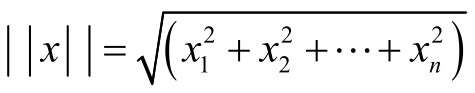

这就是L2范数。先看看用均值填充后的输入矩阵的平均范数：

In [133]:
np.sqrt((pima_imputed**2).sum(axis=1)).mean()

223.3622202582376

引入行归一化：

In [135]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
pima_normalized = pd.DataFrame(normalizer.fit_transform(pima_imputed),
                              columns=pima_column_names)
np.sqrt((pima_normalized**2).sum(axis=1)).mean()

1.0

归一化之后，所有行的范数都是1。看看这个方法在流水线上表现如何：

In [136]:
knn_params = {
    'imputer__strategy': ['mean', 'median'],
    'classify__n_neighbors': list(range(1,8))
}

pipe = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('normalize', Normalizer()),
    ('classify', KNeighborsClassifier())
])

X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

grid = GridSearchCV(pipe, knn_params)
grid.fit(X, y)

grid.best_score_, grid.best_params_

(0.7006111535523301,
 {'classify__n_neighbors': 7, 'imputer__strategy': 'median'})

效果不怎么样，但值得试试。现在我们知道了3种不同的数据标准化方法，把它们整合在一起，看看如何处理这个数据集吧。

很多算法会受尺度的影响，下面就是其中一些流行的学习算法：

- KNN——因为依赖欧几里得距离
- K均值聚类——和KNN的原因一样
- 逻辑回归、支持向量机、神经网络——如果使用梯度下降来学习权重
- 主成分分析——特征向量将偏向较大的列

### 综合比较

处理了数据集的各种问题（包括识别隐藏为0的缺失值，填充缺失值，以及按不同比例标准化数据），现在可以列出所有的得分，看看哪种办法最好。

| 描述 | 使用的行数  | 交叉验证准确率 |
| :--  | :--: | :--: |
| 删除存在缺失的行 | 392 | 0.7348 |
| 用0填充 | 768 | 0.7409 |
| 用均值填充 | 768 | 0.7318 |
| 用均值填充，z分数标准化 | 768 | 0.7539 |
| 用均值填充，min-max标准化 | 768 | 0.7630 |
| 用均值填充，行归一化 | 768 | 0.7006 |

通过这一系列探索和比较，我们通过均值填充和min-max标准化得到了目前为止（基于KNN算法）的最好结果，而且使用了全部768行。